In [26]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import os
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)
maxEpoch=50
if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2022-11-03 16:42:27.107520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:42:27.108182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:42:27.108671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:42:27.109269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:42:27.109811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
tfds.list_builders()

2022-11-03 16:23:30.233032: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


['c4',
 'c4_wsrs',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'civil_comments',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2003',
 'controlled_noisy_web_labels',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'criteo',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_antmaze',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'd4rl_mujoco_hopper',
 'd4rl_mujoco_walker2d',
 'dart',
 'davis',
 'deep1b',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'diamonds',
 'dmlab',
 'doc_nli',
 'dolphin

In [4]:
ds = tfds.load('resisc45', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)



<PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


2022-11-03 16:23:31.200884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:23:31.201245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:23:31.201492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:23:31.201817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:23:31.202047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

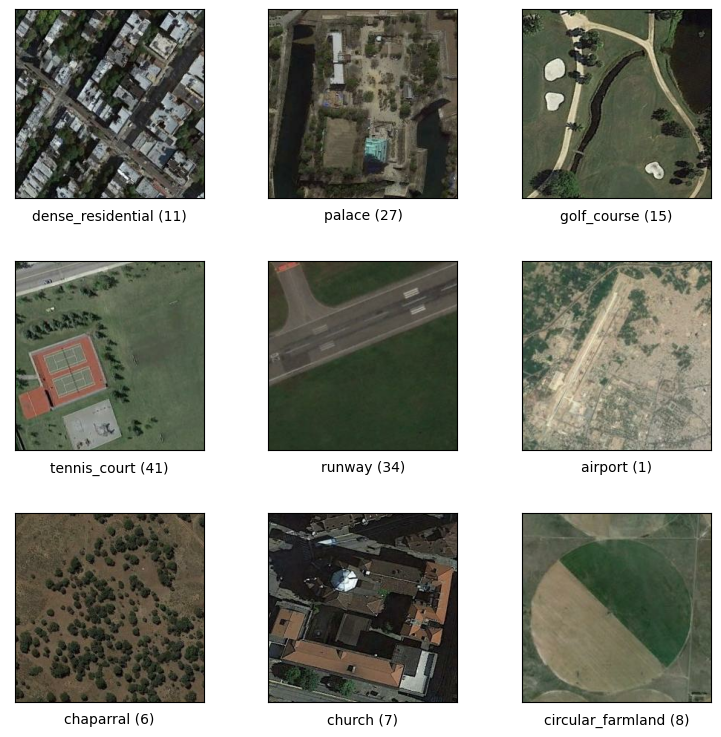

tfds.core.DatasetInfo(
    name='resisc45',
    full_name='resisc45/3.0.0',
    description="""
    RESISC45 dataset is a publicly available benchmark for Remote Sensing Image
    Scene Classification (RESISC), created by Northwestern Polytechnical University
    (NWPU). This dataset contains 31,500 images, covering 45 scene classes with 700
    images in each class.
    """,
    homepage='http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html',
    data_path='/home/nate/tensorflow_datasets/resisc45/3.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=407.97 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(256, 256, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=45),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=31500, num_shards=4>,
    },
    citation="""@articl

In [5]:
ds, ds_info = tfds.load('resisc45', split='train', with_info=True)
fig = tfds.show_examples(ds, ds_info)

print(ds_info)

In [39]:


data_dir = pathlib.Path("/home/nate/tensorflow_datasets/downloads/manual/NWPU-RESISC45/")



In [40]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


31500


In [24]:
airplane = list(data_dir.glob('airplane/*'))
PIL.Image.open(str(airplane[0]))

/home/nate/.keras/datasets/flower_photos
